## Задание  
Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH  
Библиотеки: [Python, Tensorflow]

## Переключение версии TensorFlow

In [ ]:
%tensorflow_version 2.x

In [1]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
if 0:
    !pip install scikit-video==1.1.11
import skvideo.io

Для использования skvideo в Windows необходимо наличие FFmpeg. Путь к исполняемым файлам (\bin) должен быть прописан в системной переменной PATH.

## Загрузка и распаковка датасета KTH

In [3]:
if 0:
    !wget http://www.csc.kth.se/cvap/actions/walking.zip
    !wget http://www.csc.kth.se/cvap/actions/jogging.zip
    !wget http://www.csc.kth.se/cvap/actions/running.zip
    !wget http://www.csc.kth.se/cvap/actions/boxing.zip
    !wget http://www.csc.kth.se/cvap/actions/handwaving.zip
    !wget http://www.csc.kth.se/cvap/actions/handclapping.zip 

if 0:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

## Подготовка датасета для классификации

In [4]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './data/KTH'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [5]:
print('Dataset samples (total):', len(dataset))

SUBSET_LEN = 180
random.shuffle(dataset)
dataset = dataset[:SUBSET_LEN]

print('Dataset samples (subset):', len(dataset))

Dataset samples (total): 599
Dataset samples (subset): 180


## Визуализация кадра и "движения" из видео

In [6]:
inp_video = skvideo.io.vread(dataset[0][0])
inp_video = inp_video.astype(np.float32) / 255.
inp_motion = np.mean(inp_video[1:, ...] - inp_video[:-1, ...], axis=3, keepdims=True)

In [7]:
def show_frame(video, motion, frame_num):
    fig = plt.figure(figsize=(10,4))

    print('video shape:', video.shape)
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(video[frame_num, ...], cmap='gray')
    print('motion shape:', motion.shape)
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(motion[frame_num, ..., 0], cmap='gray')

video shape: (572, 120, 160, 3)
motion shape: (571, 120, 160, 1)


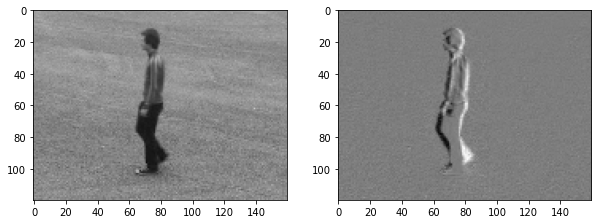

In [8]:
show_frame(inp_video, inp_motion, 50)

## Проигрывание видео из "движений"

In [9]:
import cv2

In [10]:
def show_video(videodata, class_name):
    flag = True
    while flag:
        for i in range(videodata.shape[0]):
            cv2.imshow(class_name, videodata[i, ...])
            if cv2.waitKey(1) & 0xFF == ord("q"):
                flag = False
                break
    cv2.destroyAllWindows()

In [11]:
show_video(inp_motion, classes[dataset[0][1]])

## Предобработка видео

Для того чтобы объединить тензоры в батчи необходимо их привести к унифицированной форме.  
В этом нам поможет класс Videos из библиотеки mydia https://github.com/MrinalJain17/mydia

In [12]:
if 0:
    !pip install mydia
from mydia import Videos

In [13]:
TARG_WIDTH = 128
TARG_HEIGHT = 96
TARG_FRMS = 201

In [14]:
reader = Videos(target_size=(TARG_WIDTH, TARG_HEIGHT),
                to_gray=True,
                num_frames=TARG_FRMS,
                mode='middle',
                normalize=True
               )

In [15]:
out_video = reader.read(dataset[0][0])[0]
out_motion = out_video[1:, ...] - out_video[:-1, ...]

  0%|                                                                                        | 0/1 [00:00<?, ?videos/s]C:\Users\Kartsev.ES\Anaconda3\lib\site-packages\mydia\mydia.py:234: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  video_tensor = np.vstack(map(self._read_video, paths_iterator))
100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92videos/s]


video shape: (201, 96, 128, 1)
motion shape: (200, 96, 128, 1)


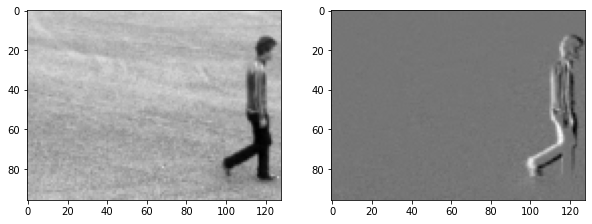

In [16]:
show_frame(out_video, out_motion, 50)

In [17]:
show_video(out_motion, classes[dataset[0][1]])

## Создание пайплайна данных

In [18]:
BATCH_SIZE = 6
NUM_EPOCHS = 10

pos = int(len(dataset)*0.8)
train_ds = dataset[:pos]
test_ds = dataset[pos:]

In [19]:
def get_data(type_ds=1):
    if type_ds == 1:
        for fpath, label in train_ds:
            videodata = reader.read(fpath, verbose=0)[0, ...]
            motion = videodata[1:, ...] - videodata[:-1, ...]
            yield motion, label
    elif type_ds == 2:
        for fpath, label in test_ds:
            videodata = reader.read(fpath, verbose=0)[0, ...]
            motion = videodata[1:, ...] - videodata[:-1, ...]
            yield motion, label
    else:
        print("generator function called with an argument not in [1, 2]")
        raise ValueError()

In [20]:
train_dataset = tf.data.Dataset.from_generator(
    get_data,
    args=([1]),
    output_signature=(
        tf.TensorSpec(shape=(200, 96, 128, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)))

train_dataset = train_dataset.shuffle(buffer_size=len(train_ds), seed=42)
#train_dataset = train_dataset.repeat(NUM_EPOCHS)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [21]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(6, 200, 96, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(6,), dtype=tf.int32, name=None))>

In [22]:
motions, labels = next(iter(train_dataset.take(1)))
motions.shape

TensorShape([6, 200, 96, 128, 1])

In [23]:
labels.shape

TensorShape([6])

In [24]:
test_dataset = tf.data.Dataset.from_generator(
    get_data,
    args=([2]),
    output_signature=(
        tf.TensorSpec(shape=(200, 96, 128, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)))

test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Создание модели CNN

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation=None),
])

In [26]:
out = model(motions)
print('Output shape:', out.shape)

Output shape: (6, 6)


## Подготовка к обучению

In [27]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.0005

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/cnn3D', 
    write_graph=False, update_freq=100, profile_batch=0)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3)

## Обучение модели

In [28]:
history = model.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    validation_data=test_dataset,
    callbacks=[tensorboard_callback, es_callback])

Epoch 1/10
24/24 [==============================] - 629s 23s/step - loss: 1.7909 - val_loss: 1.7756
Epoch 2/10
24/24 [==============================] - 631s 23s/step - loss: 1.7582 - val_loss: 1.6808
Epoch 3/10
24/24 [==============================] - 633s 23s/step - loss: 1.5843 - val_loss: 1.3837
Epoch 4/10
24/24 [==============================] - 616s 22s/step - loss: 1.3214 - val_loss: 1.2156
Epoch 5/10
24/24 [==============================] - 626s 23s/step - loss: 1.1820 - val_loss: 1.1497
Epoch 6/10
24/24 [==============================] - 631s 23s/step - loss: 1.0444 - val_loss: 1.0136
Epoch 7/10
24/24 [==============================] - 626s 23s/step - loss: 0.8799 - val_loss: 1.0210
Epoch 8/10
24/24 [==============================] - 640s 24s/step - loss: 0.8611 - val_loss: 0.9292
Epoch 9/10
24/24 [==============================] - 628s 23s/step - loss: 0.7940 - val_loss: 0.9100
Epoch 10/10
24/24 [==============================] - 642s 23s/step - loss: 0.7504 - val_loss: 1.0039

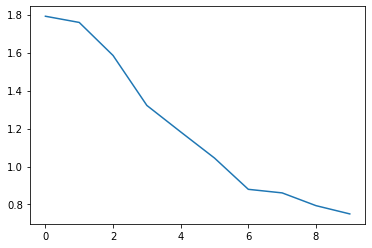

In [29]:
plt.plot(history.history['loss'])

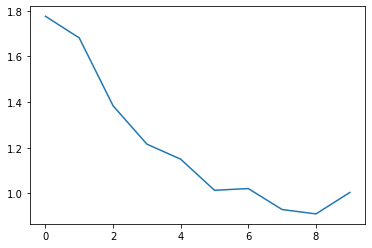

In [30]:
plt.plot(history.history['val_loss'])

## Тестирование обученной модели

In [31]:
def get_result(fpath, cls_true):
    video = reader.read(fpath)[0]
    motion = video[1:, ...] - video[:-1, ...]
    
    show_frame(video, motion, 30)
    
    out = model(motion[None, ...])[0]
    cls_pred = np.argmax(out.numpy())

    print('True class:', classes[cls_true])
    print('Predicted class:', classes[cls_pred])

100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07videos/s]


video shape: (201, 96, 128, 1)
motion shape: (200, 96, 128, 1)
True class: handclapping
Predicted class: handclapping


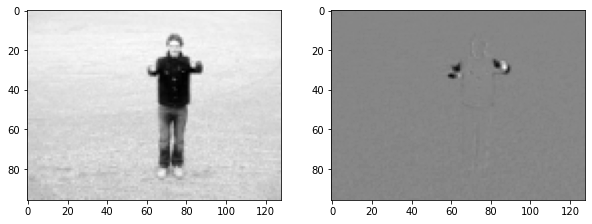

In [35]:
fpath, cls_true = random.choice(dataset)
get_result(fpath, cls_true)

100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01videos/s]


video shape: (201, 96, 128, 1)
motion shape: (200, 96, 128, 1)
True class: handwaving
Predicted class: handwaving


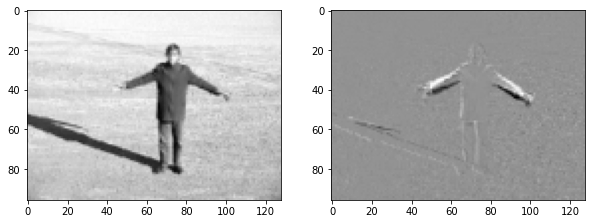

In [36]:
fpath, cls_true = random.choice(dataset)
get_result(fpath, cls_true)

100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92videos/s]


video shape: (201, 96, 128, 1)
motion shape: (200, 96, 128, 1)
True class: jogging
Predicted class: jogging


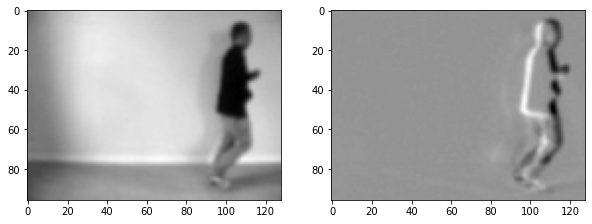

In [40]:
fpath, cls_true = random.choice(dataset)
get_result(fpath, cls_true)